# Residual CNN Autoencoders

In [38]:
!pip install tensorflow==2.2.0rc4

     |████████████████████▍           | 111.5MB 17.2MB/s eta 0:00:04    |██████████████                  | 76.7MB 17.5MB/s eta 0:00:06     |███████████████▎                | 83.6MB 17.5MB/s eta 0:00:06MB/s eta 0:00:14^C
ERROR: Exception:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pip/_internal/cli/base_command.py", line 153, in _main
    status = self.run(options, args)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pip/_internal/commands/install.py", line 382, in run
    resolver.resolve(requirement_set)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pip/_internal/legacy_resolve.py", line 201, in resolve
    self._resolve_one(requirement_set, req)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pip/_internal/legacy_resolve.py", line 365, in _resolve_one
    abstract_dist = self._get_abstract_di

In [2]:
print(tf.__version__)
print(tf.keras.__version__)

2.2.0-rc3
2.3.0-tf


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Activation, Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, AveragePooling2D, add, UpSampling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    # add filters, assumes filters/channels last
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = layersActivation('relu')(layer_out)
    return layer_out

def residual_transpose_module(layer_in, n_filters):
    merge_input = layer_in
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2DTranspose(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv1
    conv1 = Conv2DTranspose(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = Conv2DTranspose(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    # add filters, assumes filters/channels last
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = Activation('relu')(layer_out)
    return layer_out

## MNIST

In [17]:
from tensorflow.keras.datasets import mnist

# The data, shuffled and split between train and test sets:
(X_train, _), (X_test, _) = mnist.load_data()

X_train = np.reshape(X_train.astype('float32') / 255, (X_train.shape[0], 28, 28, 1))
X_test = np.reshape(X_test.astype('float32') / 255, (X_test.shape[0], 28, 28, 1))

print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


https://blog.keras.io/building-autoencoders-in-keras.html

In [18]:
from tensorflow.keras.layers import Dense, Flatten, Layer, Reshape
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding the image."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [19]:
latent_dim = 2

In [20]:
# define model input
encoder_inputs = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z])

encoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 3136)         0           conv2d_3[0][0]                   
____________________________________________________________________________________________

In [21]:
latent_inputs = Input(shape=(latent_dim, ))
x = Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoded = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder = Model(latent_inputs, decoded)

decoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [25]:
class VAE(tf.keras.Model):

    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(data, reconstruction))
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {'loss': total_loss,
                'reconstruction_loss': reconstruction_loss,
                'kl_loss': kl_loss}

autoencoder = VAE(encoder, decoder)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam())
#autoencoder.compile(optimizer='adam', loss='mean_squared_error')  

In [26]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype('float32') / 255
autoencoder.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
 75/547 [===>..........................] - ETA: 1:02 - loss: 255.0185 - reconstruction_loss: 254.2165 - kl_loss: 0.8020

KeyboardInterrupt: 

In [82]:
k = 1000
autoencoder.fit(X_train[:k], X_train[:k], batch_size=32, epochs=5, verbose=2)

ValueError: ('Error when checking model target: expected no data, but got:', array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       ...,


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]]], dtype=float32))

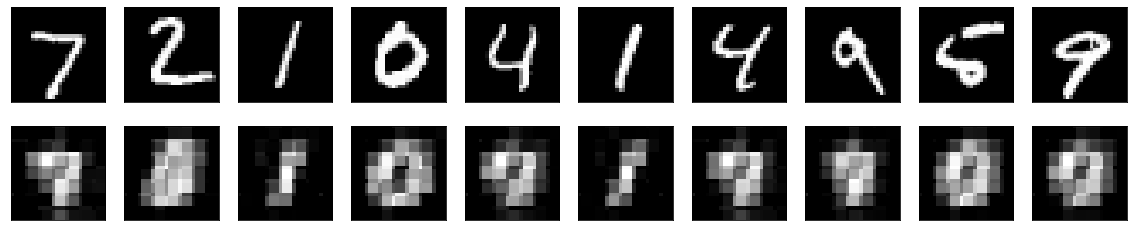

In [39]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## CIFAR-10

In [ ]:
from tensorflow.keras.datasets import cifar10

In [21]:
# The data, shuffled and split between train and test sets:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Convert class vectors to binary class matrices.
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [30]:
# define model input
input_img = Input(shape=(32, 32, 3))  # adapt this if using `channels_first` image data format
x = Conv2D(16, (2,2), padding='same', activation='relu', kernel_initializer='he_normal')(input_img)
x = residual_module(x, 4)
x = residual_module(x, 8)
encoded = AveragePooling2D((2, 2))(x)
encoder = Model(input_img, encoded)

encoded_inputs = Input(shape=encoded.shape[1:])
x = UpSampling2D((2, 2))(encoded_inputs)
x = residual_transpose_module(x, 8)
x = residual_transpose_module(x, 4)
decoded = Conv2DTranspose(3, (2,2), padding='same', activation='relu', kernel_initializer='he_normal')(x)
decoder = Model(encoded_inputs, decoded)

autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
#autoencoder.summary()

In [31]:
k = 1000
autoencoder.fit(X_train[:k], X_train[:k], batch_size=32, epochs=5, verbose=2)

Train on 10000 samples
Epoch 1/5
10000/10000 - 42s - loss: 0.5269
Epoch 2/5
10000/10000 - 40s - loss: 0.0241
Epoch 3/5
10000/10000 - 39s - loss: 0.0199
Epoch 4/5
10000/10000 - 39s - loss: 0.0174
Epoch 5/5
10000/10000 - 39s - loss: 0.0154


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


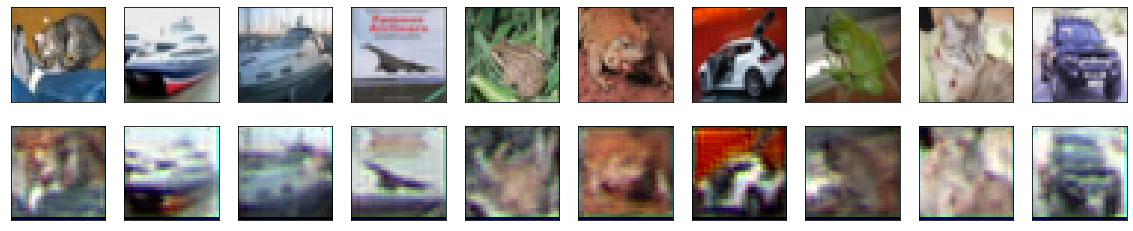

In [32]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## CIFAR-100

In [33]:
from tensorflow.keras.datasets import cifar100

In [ ]:
# The data, shuffled and split between train and test sets:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

# Convert class vectors to binary class matrices.
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
# define model input
input_img = Input(shape=(32, 32, 3))  # adapt this if using `channels_first` image data format
x = Conv2D(16, (2,2), padding='same', activation='relu', kernel_initializer='he_normal')(input_img)
x = residual_module(x, 4)
x = residual_module(x, 8)
encoded = AveragePooling2D((2, 2))(x)
encoder = Model(input_img, encoded)

encoded_inputs = Input(shape=encoded.shape[1:])
x = UpSampling2D((2, 2))(encoded_inputs)
x = residual_transpose_module(x, 8)
x = residual_transpose_module(x, 4)
decoded = residual_transpose_module(3, (2,2), padding='same', activation='relu', kernel_initializer='he_normal')(x)
decoder = Model(encoded_inputs, decoded)

autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
#autoencoder.summary()

In [ ]:
k = 1000
autoencoder.fit(X_train[:k], X_train[:k], batch_size=32, epochs=5, verbose=2)

In [ ]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()